# Client Z Recipe

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
selected_columns=[#'/: Free inodes in %', '/: Space utilization', 
                 'CPU utilization', #'Context switches per second','Load average (1m avg)','Number of processes',
                 'Interface eth0: Bits received', 'Interface eth0: Bits sent',
                 'Memory utilization',#'Free swap space in %',
                 'sda: Disk utilization',#'sda: Disk read rate', 'sda: Disk write rate'
                 ]

In [7]:
import thanos
from thanos.gen import *
from thanos.util import *
from thanos.operator import *
from thanos.SyntheticDataset import *
from thanos.rebasis import *
from copy import deepcopy

CPU times: user 9.88 s, sys: 24.6 ms, total: 9.91 s
Wall time: 9.93 s


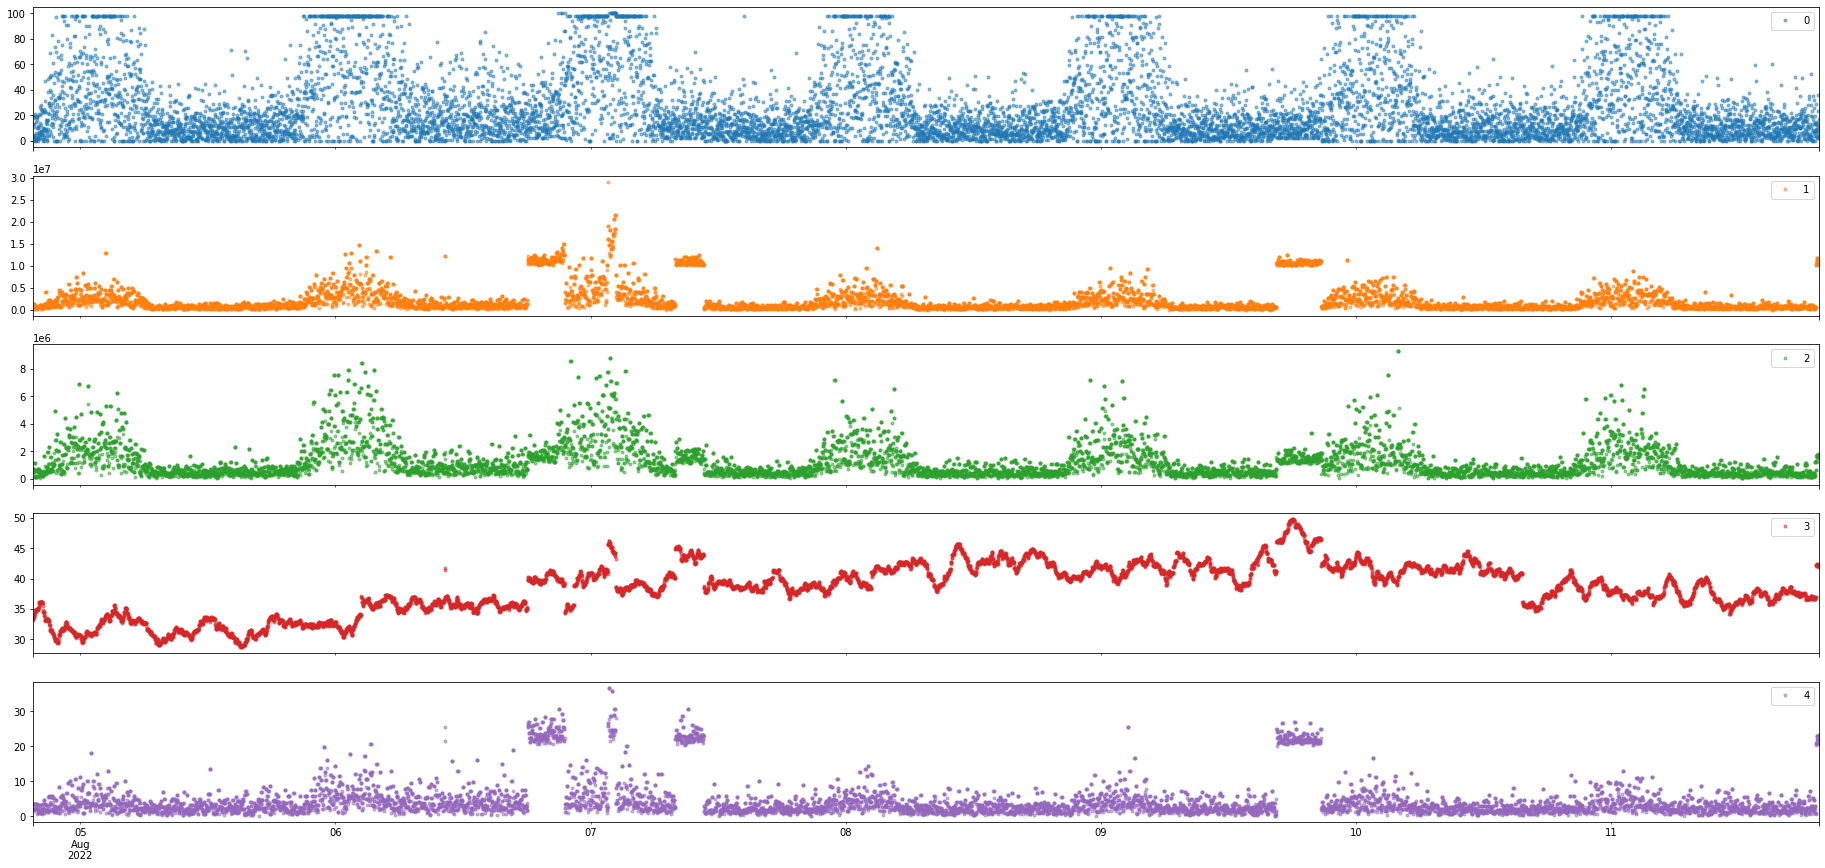

In [8]:
%%time
seed = seeded_gen(465)

statecount = 16
anomalies = BinMarkovAnomaly(seed, p_on = 0.0005, p_off = 0.01)

multinomial = (StateSelector(RandomVariable('gamma', seed, 2, 3)*3e2, # temporal changerate distribution
                            RandomVariable('integers', seed, 0, statecount), # state selection distribution
                            [ConstantVariable(RandomVariable('uniform', seed, 20, 30)) for i in range(statecount) ])) + ((RandomVariable('gamma', seed, 2.0, 3.0)-2)*3)\
                .window(90, sliding=True).apply(np.mean)\
                .window(3, sliding=True).apply(np.max)
# try taking a window mean of the noise, multistate memory/cpu

load_seasonality = Seasonality().apply(np.clip, 0.2, 1.0) * Seasonality(period=60*24*7).apply(np.clip, 0.6, 1.0)

cpu_random = ((RandomVariable('gamma', seed, 2, 3) - 1)*20 * deepcopy(load_seasonality)).apply(np.clip, 0, 98)#.window(2, sliding=True).apply(np.mean)

network_random = (RandomVariable('uniform', seed, 2e5, 1e6) * RandomVariable('gamma', seed, 2.0, 3.0) * deepcopy(load_seasonality)).window(3, sliding=True).apply(np.max)
disk_random = (RandomVariable('normal', seed, 4.0, 2.0) * Seasonality().apply(np.clip, 0.5, 1.0) * Seasonality(period=60*24*7).apply(np.clip, 0.6, 1.0) * 
               (RandomVariable('gamma', seed, 2.0, 3.0)/5) ).apply(np.clip, 0.0, 100.0).window(3, sliding=True).apply(np.max)

composed_example = ReBasis(seeded_gen(123), np.array([[2.0, 0.0, 0.0, 0.0, 1.0], # cpu
                                                      [1e7, 0.0, 1.0, 0.0, 0.0], # recv
                                                      [1e6, 0.0, 0.7, 0.0, 0.0], # sent
                                                      [5.0, 1.0, 0.0, 0.0, 0.0], # mem - add gaussian noise
                                                      [20.0, 0.0, 0.0, 1.0, 0.0], # disk
                                                     ]), 
                           [anomalies, multinomial, network_random, disk_random, cpu_random])
plot_examples(composed_example)

In [9]:
for i, vector in zip(range(10), composed_example):
    cpu_value = vector[0]

In [10]:
anomalies = composed_example._recurse_helper(composed_example, "get_event_indexes")

In [11]:
anomalies

{'ReBasis([2. 0. 0. 0. 1.],[1.e+07 0.e+00 1.e+00 0.e+00 0.e+00],[1.e+06 0.e+00 7.e-01 0.e+00 0.e+00],[5. 1. 0. 0. 0.],[20.  0.  0.  1.  0.]).signals.0.0BinMarkovAnomaly(0.0005,0.01)': [(2323,
   2325),
  (2791, 3001),
  (3245, 3289),
  (3625, 3786),
  (7018, 7271),
  (10064, inf)],
 'ReBasis([2. 0. 0. 0. 1.],[1.e+07 0.e+00 1.e+00 0.e+00 0.e+00],[1.e+06 0.e+00 7.e-01 0.e+00 0.e+00],[5. 1. 0. 0. 0.],[20.  0.  0.  1.  0.]).signals.1.0BinMarkovAnomaly(0.0005,0.01)': [(2323,
   2325),
  (2791, 3001),
  (3245, 3289),
  (3625, 3786),
  (7018, 7271),
  (10064, inf)],
 'ReBasis([2. 0. 0. 0. 1.],[1.e+07 0.e+00 1.e+00 0.e+00 0.e+00],[1.e+06 0.e+00 7.e-01 0.e+00 0.e+00],[5. 1. 0. 0. 0.],[20.  0.  0.  1.  0.]).signals.2.0BinMarkovAnomaly(0.0005,0.01)': [(2323,
   2325),
  (2791, 3001),
  (3245, 3289),
  (3625, 3786),
  (7018, 7271),
  (10064, inf)],
 'ReBasis([2. 0. 0. 0. 1.],[1.e+07 0.e+00 1.e+00 0.e+00 0.e+00],[1.e+06 0.e+00 7.e-01 0.e+00 0.e+00],[5. 1. 0. 0. 0.],[20.  0.  0.  1.  0.]).signals.3.

In [12]:

for key,v in anomalies.items():
    anomaly_indices = v
    break

In [13]:
print(len(anomaly_indices))
anomaly_indices

6


[(2323, 2325),
 (2791, 3001),
 (3245, 3289),
 (3625, 3786),
 (7018, 7271),
 (10064, inf)]

# Synthesize a Dataset

In [14]:
%%time
agent_z_train = fromiter(composed_example.reset(), float, count=26*7*24*60) # 26 weeks
agent_z_test = fromiter(composed_example, float, count=4 * 7 * 24* 60) # 4 weeks

[[<thanos.gen.BinMarkovAnomaly object at 0x7fdd6a6e1ca0>, <thanos.gen.op object at 0x7fdd6a6e1d30>, <thanos.gen.uniop object at 0x7fdd6a6aef70>, <thanos.gen.uniop object at 0x7fdd6a6e1100>, <thanos.gen.uniop object at 0x7fdd6a6b3340>], [<thanos.gen.BinMarkovAnomaly object at 0x7fdd6a63c220>, <thanos.gen.op object at 0x7fdd6a63c160>, <thanos.gen.uniop object at 0x7fdd6a6d8580>, <thanos.gen.uniop object at 0x7fdd6a63f8e0>, <thanos.gen.uniop object at 0x7fdd6a642dc0>], [<thanos.gen.BinMarkovAnomaly object at 0x7fdd6a6470d0>, <thanos.gen.op object at 0x7fdd6a647100>, <thanos.gen.uniop object at 0x7fdd6a641ca0>, <thanos.gen.uniop object at 0x7fdd6a650f40>, <thanos.gen.uniop object at 0x7fdd6a651a60>], [<thanos.gen.BinMarkovAnomaly object at 0x7fdd6a6519a0>, <thanos.gen.op object at 0x7fdd6a64e4c0>, <thanos.gen.uniop object at 0x7fdd6a651eb0>, <thanos.gen.uniop object at 0x7fdd6a656bb0>, <thanos.gen.uniop object at 0x7fdd6a656dc0>], [<thanos.gen.BinMarkovAnomaly object at 0x7fdd6a65d9a0>, <t

In [16]:
now = pd.Timestamp.now().round('min')
train_index = pd.date_range(end=now, freq='1min', periods=agent_z_train.shape[0])
agent_z_train_df = pd.DataFrame(agent_z_train, columns=selected_columns, index=train_index)
agent_z_train_df.index.name = "TIMESTAMP"
test_index = pd.date_range(start=now+pd.Timedelta(minutes=1), freq='1min', periods=agent_z_test.shape[0])
agent_z_test_df = pd.DataFrame(agent_z_test, columns=selected_columns, index=test_index)
agent_z_test_df.index.name = "TIMESTAMP"

array([<AxesSubplot:xlabel='TIMESTAMP'>, <AxesSubplot:xlabel='TIMESTAMP'>,
       <AxesSubplot:xlabel='TIMESTAMP'>, <AxesSubplot:xlabel='TIMESTAMP'>,
       <AxesSubplot:xlabel='TIMESTAMP'>], dtype=object)

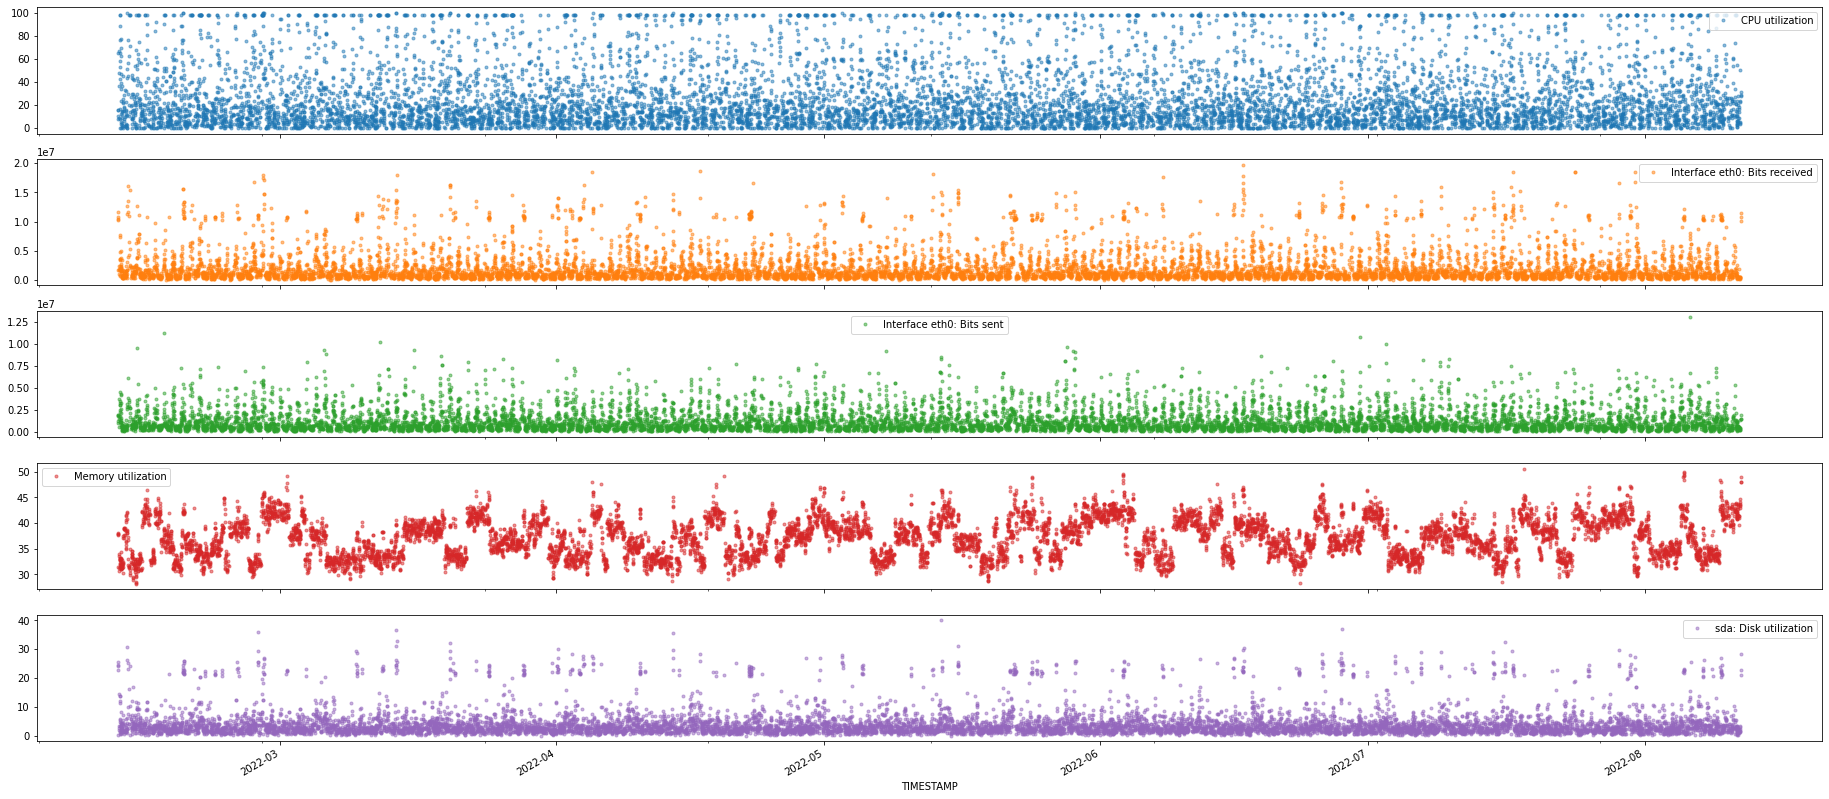

In [17]:
agent_z_train_df.sample(10000).plot(marker='.', alpha=0.5, linestyle='none', figsize=(32,3*5), subplots=True)

In [18]:
DATASET_PATH = "/data/tspub/itom/agent_zed_20220216_balanced/"

In [19]:
agent_z_train_df.to_csv(DATASET_PATH + "train/6mo_5d_2e-4_123.csv")
agent_z_test_df.to_csv(DATASET_PATH + "test/1mo_5d_2e-4_123.csv")

In [20]:
anomalies = composed_example._recurse_helper(composed_example, "get_event_indexes")
for key,v in anomalies.items():
    anomaly_indices = v
    break
    
print(len(anomaly_indices))

146


In [21]:
train_length = agent_z_train.shape[0]
train_labels = np.zeros(train_length)
test_length = agent_z_test.shape[0]
test_labels = np.zeros(test_length)

for start, end in anomaly_indices:
    if start < train_length and end < train_length:
        train_labels[start:end] = 1
    elif start < train_length and end >= train_length:
        train_labels[start:train_length] = 1
        test_labels[0:end-train_length] = 1
    elif start >= train_length and end < train_length + test_length:
        test_labels[start-train_length:end-train_length] = 1
    elif start > train_length and start < train_length+test_length:
        test_labels[start-train_length:test_length] = 1

In [22]:
agent_z_train_label_df = pd.DataFrame(train_labels, columns=["Label"], index=train_index)
agent_z_train_label_df.index.name = "TIMESTAMP"
agent_z_test_label_df = pd.DataFrame(test_labels, columns=["Label"], index=test_index)
agent_z_test_label_df.index.name = "TIMESTAMP"

agent_z_train_label_df.to_csv(DATASET_PATH + "train_label/6mo_5d_2e-4_123.csv")
agent_z_test_label_df.to_csv(DATASET_PATH + "test_label/1mo_5d_2e-4_123.csv")